### Простой U-NET

В первую очередь была обучена классическая версия u-net без аугментации, что дало базовое решение с которым будет проводится дальнейшее сравнение. Такая архитектура была выбрана на основании того, что она является относительно эффективной для решения задач семантической сегментации и при этом достаточно быстро обучается, не требуя больших вычислительных ресурсов.  

В репозитории <https://github.com/karolzak/keras-unet> представлена реализация данной архитектуры, а также её модификации. В качестве первого теста был выбран вариант сети, который возвращает маску того же размера, что и исходное изображение, т.к. в нашей задаче не требуется разбивать исходное изображение на составляющие.

В качестве фреймворка был выбран `Keras`, как наиболее простой, а также в силу того, что для него доступны готовые реализации u-net.

In [11]:
import sys

In [12]:
sys.path.append("../")

In [1]:
import pickle

In [33]:
from keras_unet_mod.models import custom_unet, sobel_unet

In [13]:
from keras_unet_mod.utils import plot_segm_history

-----------------------------------------
keras-unet init: TF version is < 2.0.0 or not present - using `Keras` instead of `tf.keras`
-----------------------------------------


In [2]:
with open("history_seg_1.pkl", 'rb') as file:
    history = pickle.load(file)

In [7]:
print(f"Dice score: {round(max(history['val_dice_score']), 2)}")

Dice score: 0.84


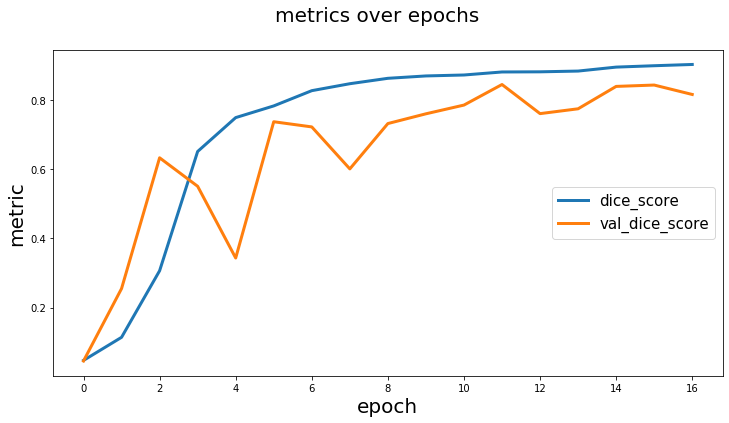

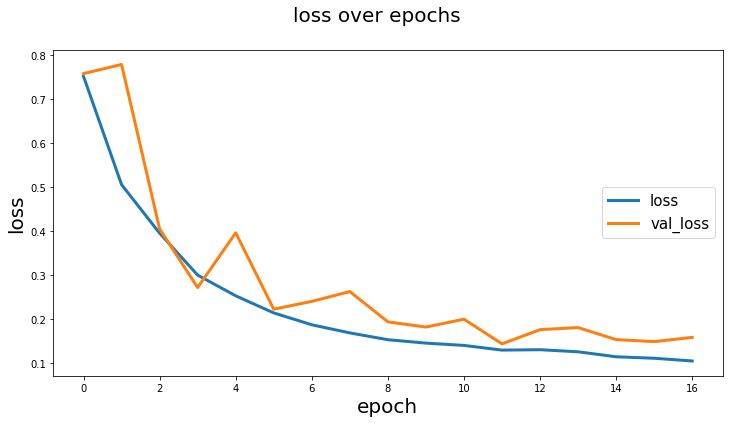

In [15]:
plot_segm_history(history, metrics=['dice_score', 'val_dice_score'], losses=['loss', 'val_loss'])

Максимальное значение коэффициента Дайса составило 0.84 для этой модели.

#### Аугментация
Далее была проведена подготовка методов для аугментации данных. Большая часть стандартных методов, таких как: вращение, масштабирование, изменение плоскости проекции, контрастности и др. уже реализованы в модуле `preprocessing` фреймворка `Keras`. Однако для данной задачи было решено немного расширить набор преобразований и с целью создания общего интерфейса всех методов было решено написать отдельный моудль `preprocessing`, который стал частью пакета `lib` исходного проекта.

В исходных изображениях ввиду их искусственного происхождения отсутствуют тени от окурков на фоне. Чтобы сделать внедрение окурка в сцену более реалистичным был реализован метод имитирующий тень от окурка на фоне при освещени бесконечно удалённым объектом при разных направлениях, а также тень на самом окурке, которая возникает из-за его цилиндрической формы.

Вторым дополнением к совокупности преобразований было рисование посторонних объектов, выделяющихся на фоне, но не являющихся окурком. Идея состоит в том, чтобы стимулировать запоминание целевого класса посредством контрпримеров.

Третье преобразование тоже связано с рисованием новых объектов, однако их цель -- выработать устойчивость сети к перекрытию целевого объекта объектами других классов. Такая ситуация часто возникает на реальных изображениях, когда окурок частично перекрывается. С целью имитровать такую ситуацию, окурки на синтетических изображениях перекрываются нарисованными примитивами.

В итоге были реализованы:
1. Повороты и отражения
2. Гауссово размытие
3. Изменение масштаба с сохранием целевого объекта
4. Изменение констрасности и яркости
5. Рисование не перекрывающих и перекрывающих объектов
6. Имитация теней

После тестирования этих преобразований выяснилось, что сильно мешает обучению размытие и уменьшение зума, поэтому от них решено было отказаться. Перекрытие также ухудшило результаты.

При преобразовании исходных изображений было рассмотрено два режима. Первый соотвествует преобразованию по цепочке от одного метода к другому, однако он оказался достаточно затратным с точки зрения вычислений и серьёзно затормозил процесс тестирования. Поэтому был рассмотрен второй режим, при котором каждому изображению случайным образом выбирается одно преобразование перед подачей в нейронную сеть.

Результаты тестирования простой u-net с аугментацией:

In [19]:
with open("history_custom_unet_12.pkl", 'rb') as file:
    history = pickle.load(file)

In [20]:
print(f"Dice score: {round(max(history['val_dice_score']), 2)}")

Dice score: 0.85


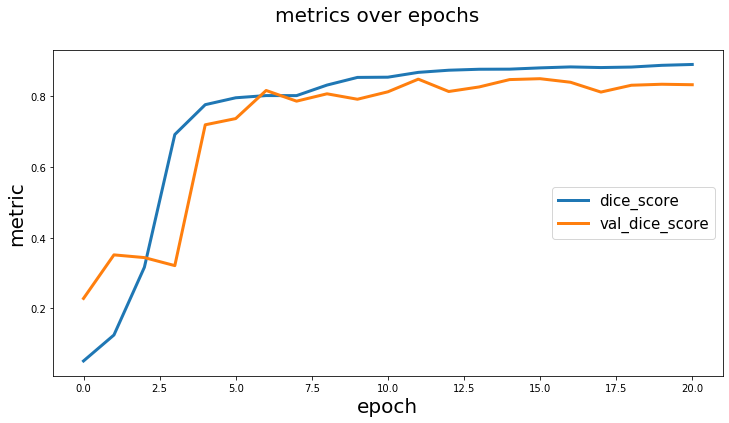

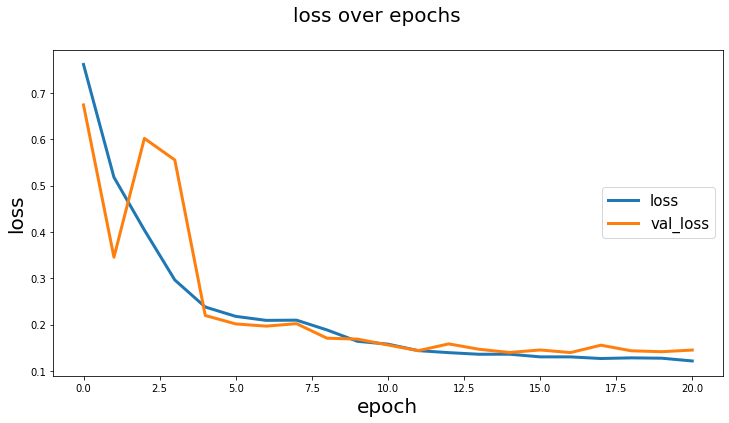

In [21]:
plot_segm_history(history, metrics=['dice_score', 'val_dice_score'], losses=['loss', 'val_loss'])

Результат практически остался неизменным.

### U-NET с оператором Соболева.

Для выделения контуров отдельных объектов ещё очень давно использовались различные свёртки изображения. Одна из них это оператор Соболева. Идея метода базируется на том, что на границах предметов возникает резкий перепад яркости. С помощью данного оператора можно оценить модуль градиента изображения в каждой точке, максимумы градиента с высокой вероятностью указывают на границу объекта или материала.

Чтобы помочь сети получить информацию о границах объектов было решено попробывать ввести дополнительную ветвь с данным фильтром.

Ветвь просто соединяет исходное изображение с последним декодирующим блоком. Сначала все каналы изображения фильтруются двумя свёрточными слоями с замороженными коэффициентами ядер размера 3 на 3, которые и являются коэффициентами ядра для оператора Соболева для осей x и y. Затем эти слои объединяются так, чтобы в итоге получился модуль градиента. Далее, через свёрточный блок, этот слой присоединяется к последнему свёрточному блоку u-net. 

На схеме это выглядит так:
![u-net](sobel_unet.png)

Результат обучения такой модели:

In [16]:
with open("history_seg_2.pkl", 'rb') as file:
    history = pickle.load(file)

In [17]:
print(f"Dice score: {round(max(history['val_dice_score']), 2)}")

Dice score: 0.92


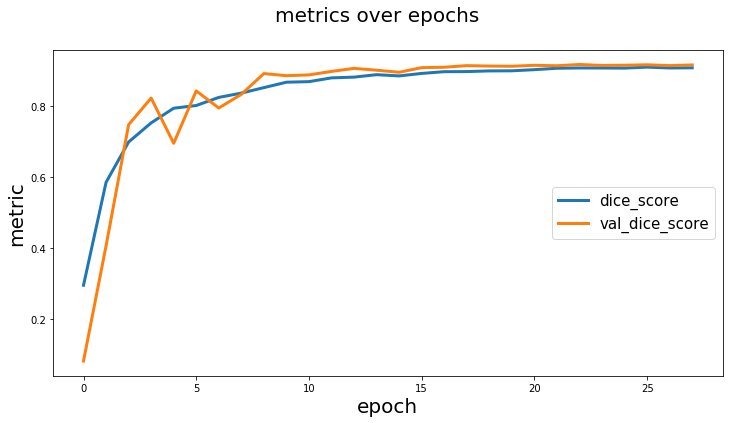

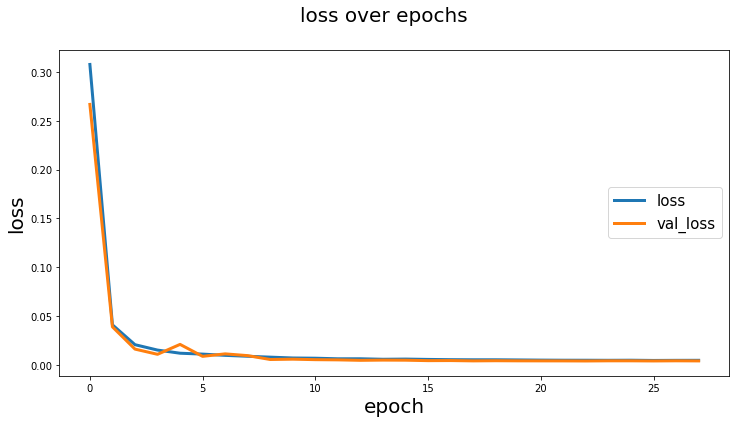

In [18]:
plot_segm_history(history, metrics=['dice_score', 'val_dice_score'], losses=['loss', 'val_loss'])

Точность на валидационных изображениях выросла на 0.7 пунктов. Однако при тесте на реальных изображениях существенной разницы не замечено, допускаются почти те же ошибки, что и у простой u-net.

#### Аугментация

При аугментации с различными параметрами точность на валидационных данных в целом снизилась.
В качетсве сторонних предметов использовались изображения с сайтов рекламы товаров, т.к. изображения на белом фоне, то для них легко сделать маску.
Также просто добавлялись произвольные прямоугольники разных цветов с размерами сопоставимыми с окурком. Перекрытия не использовались.

In [24]:
with open("history_sovel_unet_10.pkl", 'rb') as file:
    history = pickle.load(file)

In [25]:
print(f"Dice score: {round(max(history['val_dice_score']), 2)}")

Dice score: 0.9


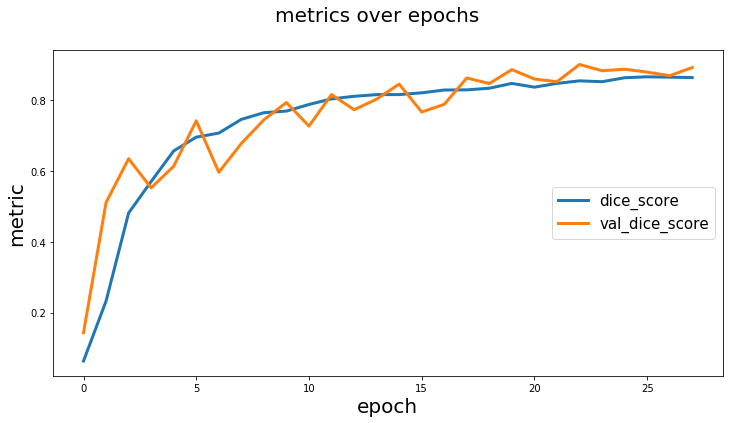

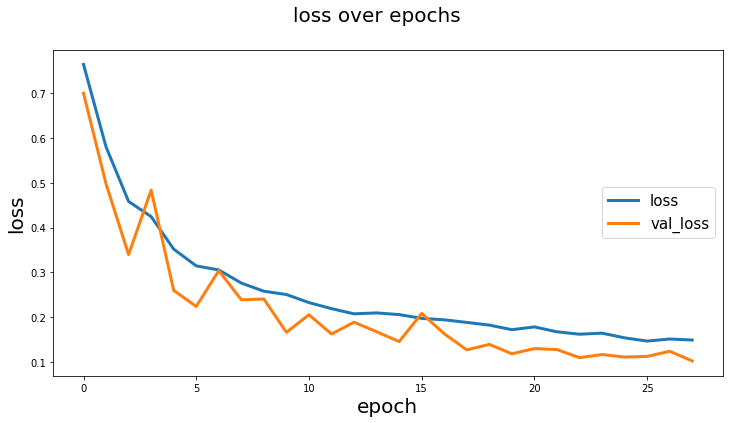

In [26]:
plot_segm_history(history, metrics=['dice_score', 'val_dice_score'], losses=['loss', 'val_loss'])

При использовании перекрытий:

In [27]:
with open("history_sovel_unet_9.pkl", 'rb') as file:
    history = pickle.load(file)

In [28]:
print(f"Dice score: {round(max(history['val_dice_score']), 2)}")

Dice score: 0.89


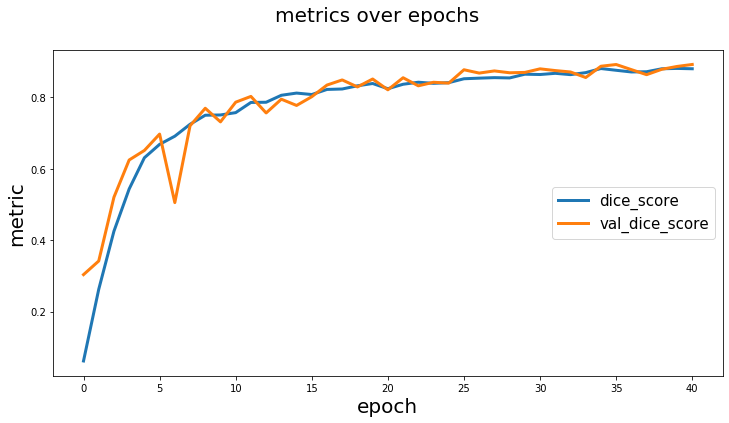

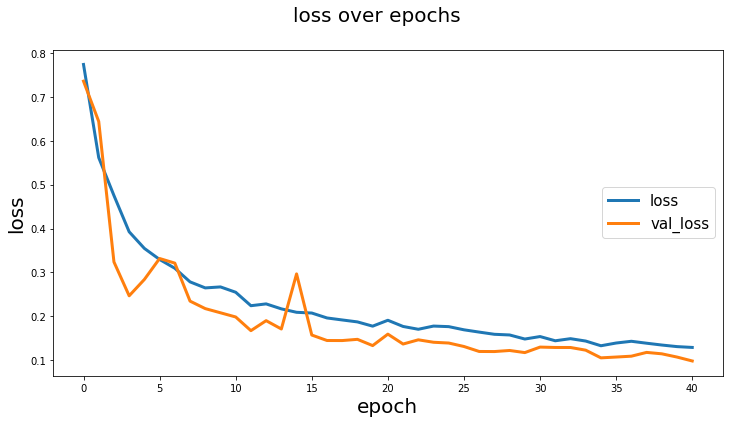

In [29]:
plot_segm_history(history, metrics=['dice_score', 'val_dice_score'], losses=['loss', 'val_loss'])

Обучается намного дольше и точность немного ниже, чем без них.

При использовании размытия обучение длилось достаточно долго.

Dice score: 0.84


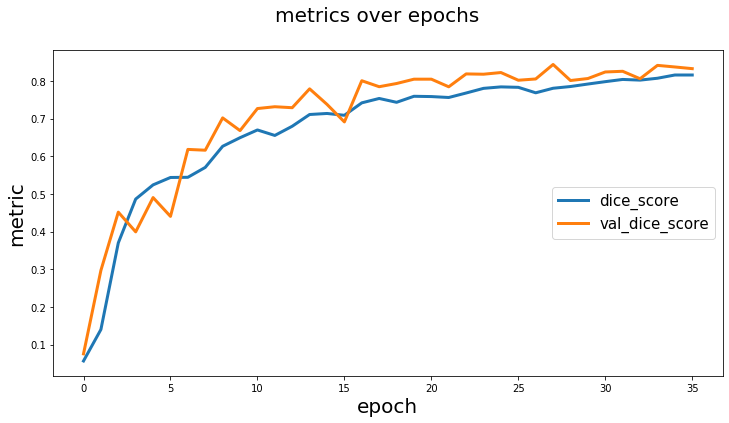

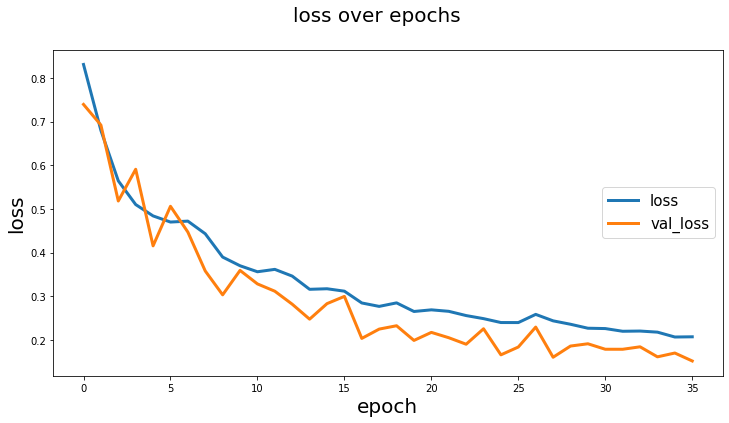

In [31]:
with open("history_sovel_unet_7.pkl", 'rb') as file:
    history = pickle.load(file)

print(f"Dice score: {round(max(history['val_dice_score']), 2)}")

plot_segm_history(history, metrics=['dice_score', 'val_dice_score'], losses=['loss', 'val_loss'])

Но потом было принято решение ещё дообучить модель:

Dice score: 0.9


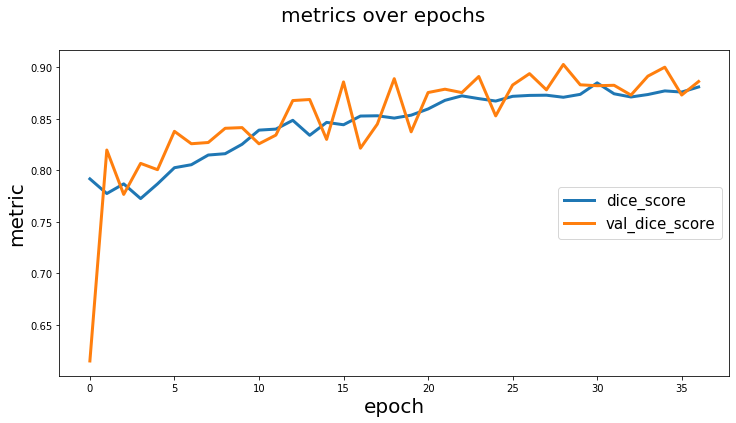

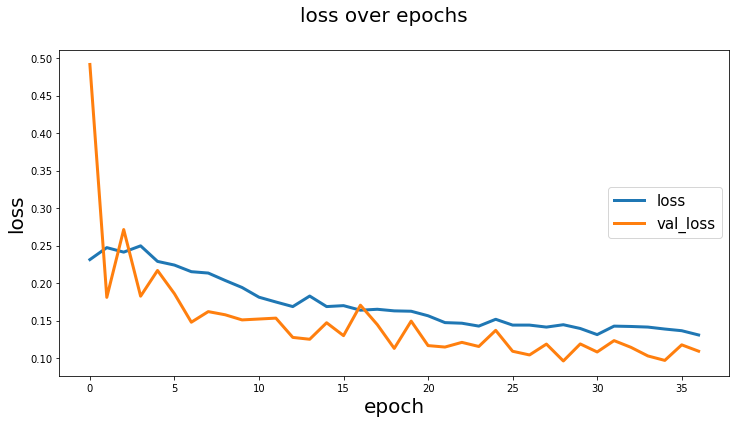

In [32]:
with open("history_sovel_unet_8.pkl", 'rb') as file:
    history = pickle.load(file)

print(f"Dice score: {round(max(history['val_dice_score']), 2)}")

plot_segm_history(history, metrics=['dice_score', 'val_dice_score'], losses=['loss', 'val_loss'])

И снова был получен примерно такой же результат.

На реальных изображения все модели допускают примерно одинаковые ошибки. Наблюдения показывают, что труднее всего даются белые окурки на светлом фоне.